In [5]:
# Run in a notebook cell with `!` or in terminal.
!pip install pandas scikit-learn matplotlib wordcloud seaborn nltk tqdm

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import pandas as pd


In [6]:
df=pd.read_csv("labeled_level1_repaired.csv")

In [7]:
df.head()

,from,sender_domain,clean_text,deadline_date,label_source,label_topic,label_urgency,rule_label
0,23DCS023 JAMES DHANDHUKIYA <23dcs023@charusat....,charusat.edu.in,request for email data contribution – research...,NaN,Misc,NaN,NaN,SGP / Project Related
1,23DCS023 JAMES DHANDHUKIYA <23dcs023@charusat....,charusat.edu.in,re: request for email data contribution – rese...,NaN,Misc,NaN,NaN,SGP / Project Related
2,NPTEL <onlinecourses@nptel.iitm.ac.in>,nptel.iitm.ac.in,nptel newsletter: iit madras code certificate ...,NaN,NPTEL / External Courses,NaN,NaN,NPTEL / External Courses
3,Team at Read <support@e.read.ai>,e.read.ai,exclusive education pricing just for you! read...,NaN,Misc,NaN,NaN,Misc
4,Mohini Darji <mohinidarji.dcs@charusat.ac.in>,charusat.ac.in,reg. submission of sgp- weekly reports dear st...,NaN,SGP / Project Related,NaN,NaN,SGP / Project Related


                             count  percent
label_source                               
Exam Cell / Academic Office    833    54.30
Misc                           331    21.58
NPTEL / External Courses       140     9.13
SGP / Project Related          102     6.65
Events / Hackathons / Clubs     74     4.82
Unlabeled                       38     2.48
Administrative                  16     1.04


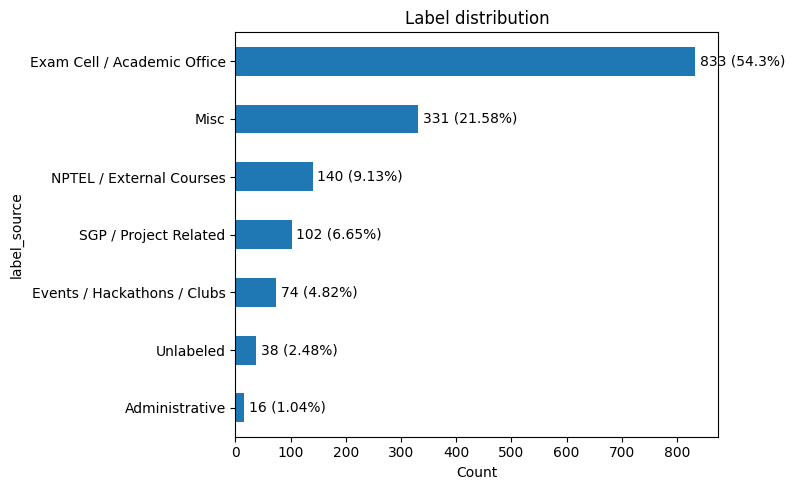

In [8]:
# show distribution of labels (counts + percentages) and plot a horizontal bar chart
label_series = df['label_source'].fillna('Unlabeled')
counts = label_series.value_counts()
percents = label_series.value_counts(normalize=True).mul(100).round(2)
dist = pd.concat([counts, percents], axis=1, keys=['count', 'percent'])
print(dist)

import matplotlib.pyplot as plt

counts_sorted = counts.sort_values(ascending=True)
plt.figure(figsize=(8, 5))
ax = counts_sorted.plot(kind='barh', color='C0')
plt.xlabel('Count')
plt.title('Label distribution')
# annotate counts on bars
for i, (idx, v) in enumerate(counts_sorted.items()):
    ax.text(v + max(counts_sorted) * 0.01, i, f"{v} ({dist.loc[idx,'percent']}%)", va='center')
plt.tight_layout()
plt.show()

In [9]:
import re
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tqdm.notebook import tqdm
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

STOP = set(stopwords.words('english'))
RND_SEED = 42

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\malan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data]   Unzipping corpora\stopwords.zip.


In [10]:
# Adjust path to your CSV
DATA_PATH = Path("labeled_level1_repaired.csv")
df = pd.read_csv(DATA_PATH, dtype=str, keep_default_na=False)

# Keep expected columns; tolerate missing
expected_cols = ['from','sender_domain','clean_text','deadline_date',
                 'label_source','label_topic','label_urgency']
for c in expected_cols:
    if c not in df.columns:
        df[c] = ""

# small cleaning helper
def norm_text(s):
    if not isinstance(s, str): return ""
    s = re.sub(r"\s+", " ", s).strip()
    return s

df['clean_text'] = df['clean_text'].astype(str).apply(norm_text)
df['sender_domain'] = df['sender_domain'].astype(str).str.lower().fillna("")
df['label_source'] = df['label_source'].astype(str).str.strip().replace({'nan':''})
print("Rows:", len(df))
df.head(2)

Rows: 1534


,from,sender_domain,clean_text,deadline_date,label_source,label_topic,label_urgency,rule_label
0,23DCS023 JAMES DHANDHUKIYA <23dcs023@charusat....,charusat.edu.in,request for email data contribution – research...,,Misc,,,SGP / Project Related
1,23DCS023 JAMES DHANDHUKIYA <23dcs023@charusat....,charusat.edu.in,re: request for email data contribution – rese...,,Misc,,,SGP / Project Related


In [11]:
def label_stats(df, col='label_source'):
    s = df[col].replace("", "Unlabeled").value_counts()
    pct = (s / len(df) * 100).round(2)
    return pd.concat([s, pct], axis=1).rename(columns={0:'count',1:'percent'})

print(label_stats(df,'label_source'))
print("\nTop sender domains:")
print(df['sender_domain'].value_counts().head(20))

                             count  count
label_source                             
Exam Cell / Academic Office    833  54.30
Misc                           331  21.58
NPTEL / External Courses       140   9.13
SGP / Project Related          102   6.65
Events / Hackathons / Clubs     74   4.82
Unlabeled                       38   2.48
Administrative                  16   1.04

Top sender domains:
sender_domain
charusat.ac.in            918
nptel.iitm.ac.in          140
charusat.edu.in            49
teachnook.com              46
e.read.ai                  45
m.learn.coursera.org       36
kodekloud.com              34
google.com                 32
hackerrankmail.com         26
gmail.com                  22
discover.pinterest.com     22
stackblitz.com             14
external.cisco.com         14
leetcode.com               13
team.kodekloud.com         10
explore.pinterest.com       9
accounts.google.com         9
krutanic.org                8
inspire.pinterest.com       7
engage.canva.com 

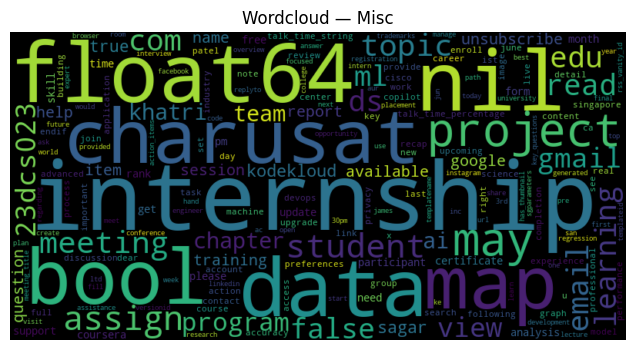

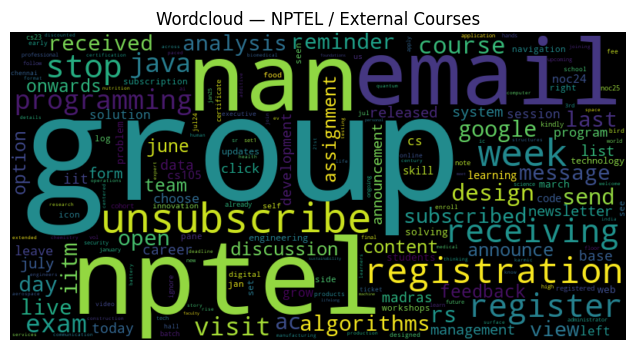

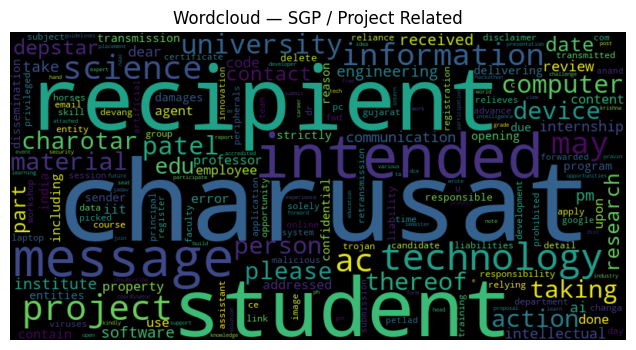

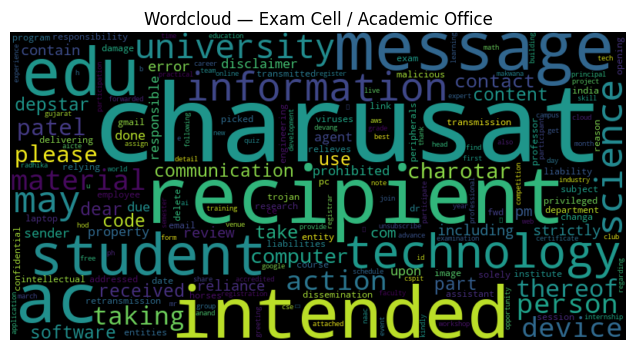

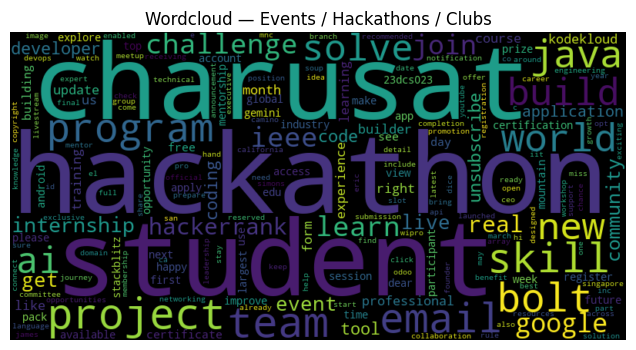

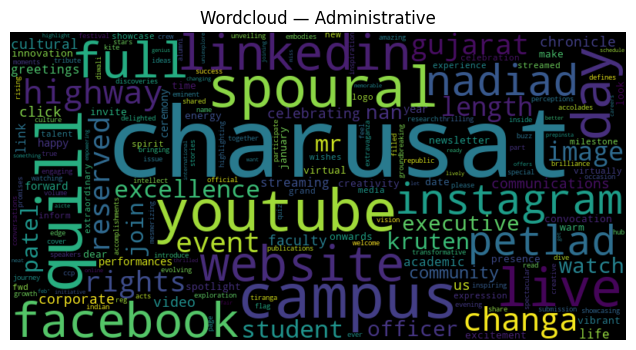

In [12]:
def build_wordcloud(text, max_words=150):
    wc = WordCloud(width=800, height=400, stopwords=STOP, collocations=False).generate(text)
    return wc

labels = df['label_source'].replace("", "Unlabeled").unique()
for lab in labels:
    texts = " ".join(df.loc[df['label_source']==lab, 'clean_text'].astype(str).values)
    if len(texts) < 50:
        continue
    plt.figure(figsize=(10,4))
    plt.title(f"Wordcloud — {lab}")
    plt.imshow(build_wordcloud(texts), interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Create count vectorizer (unigrams)
cv = CountVectorizer(stop_words='english', min_df=3, ngram_range=(1,1))
Xc = cv.fit_transform(df['clean_text'].fillna(''))
terms = np.array(cv.get_feature_names_out())

# find top terms per label
top_terms_per_label = {}
for lab in df['label_source'].replace("", "Unlabeled").unique():
    mask = df['label_source']==lab
    if mask.sum() < 5: continue
    freqs = np.asarray(Xc[mask.to_numpy()].sum(axis=0)).ravel()
    top_ix = freqs.argsort()[::-1][:30]
    top_terms_per_label[lab] = terms[top_ix].tolist()

# print compactly
for lab, terms_list in top_terms_per_label.items():
    print(lab, "→", ", ".join(terms_list[:12]))
    
# keyword mismatch rule: if an email contains many top-terms of another label, flag it
def keyword_mismatch_score(row, top_terms_per_label, top_n=5):
    t = row['clean_text'].lower()
    scores = {}
    for lab, tlist in top_terms_per_label.items():
        hits = sum(1 for k in tlist[:top_n] if f" {k} " in f" {t} ")
        scores[lab] = hits
    # suggested label = label with highest hits
    suggested_lab = max(scores, key=scores.get) if scores else None
    return suggested_lab, scores

# Example: compute mismatch for all and collect suspicious ones
suspicious_kw = []
for idx,row in df.iterrows():
    suggested, scores = keyword_mismatch_score(row, top_terms_per_label, top_n=7)
    if suggested and suggested != row['label_source'] and max(scores.values())>=2:
        suspicious_kw.append((idx,row['label_source'], suggested, scores))
len(suspicious_kw)

AttributeError: 'Series' object has no attribute 'nonzero'

In [ ]:
# simple domain rules (tune as needed)
def domain_expected_label(domain):
    if domain.endswith("charusat.edu.in"):
        return "Misc"
    if domain.endswith("charusat.ac.in"):
        return None  # ambiguous: need content-based rules
    if "nptel" in domain or "coursera" in domain:
        return "NPTEL / External Courses"
    if any(d in domain for d in ["pinterest","mailchimp","sendgrid","read.ai"]):
        return "Misc"
    return None

domain_mismatches = []
for idx,row in df.iterrows():
    dom = row['sender_domain']
    expected = domain_expected_label(dom)
    if expected and row['label_source'] != expected:
        domain_mismatches.append((idx, row['sender_domain'], row['label_source'], expected))
len(domain_mismatches)
# show sample
pd.DataFrame(domain_mismatches[:50], columns=['index','domain','current','expected']).head()

In [ ]:
# prepare TF-IDF
vec = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=3, ngram_range=(1,2))
X = vec.fit_transform(df['clean_text'].fillna(''))

# dimensionality reduction
svd = TruncatedSVD(n_components=120, random_state=RND_SEED)
X_reduced = svd.fit_transform(X)

# cluster by current label (centroid per label)
labels_unique = [l for l in df['label_source'].replace("", "Unlabeled").unique()]
label_to_idx = {l: i for i,l in enumerate(labels_unique)}
centroids = {}
for lab in labels_unique:
    mask = df['label_source']==lab
    if mask.sum() < 5:
        centroids[lab] = None
        continue
    centroids[lab] = X_reduced[mask.values].mean(axis=0)

# compute cosine distance to centroid of its assigned label
distances = np.full(len(df), np.nan)
for idx,row in df.iterrows():
    lab = row['label_source'] if row['label_source']!="" else "Unlabeled"
    cent = centroids.get(lab)
    if cent is None:
        distances[idx] = np.nan
    else:
        distances[idx] = cosine_distances(X_reduced[idx:idx+1], cent.reshape(1,-1))[0,0]

df['centroid_dist'] = distances

# For each label, compute z-score distance and mark high outliers
df['centroid_z'] = df.groupby('label_source')['centroid_dist'].transform(
    lambda x: (x - np.nanmean(x)) / (np.nanstd(x) + 1e-9)
    )

# suspicious by semantic distance (z > threshold)
SEMANTIC_Z_THRESH = 2.0
semantic_suspicious = df[(df['centroid_z'] > SEMANTIC_Z_THRESH)].copy()
print("Semantic suspicious count:", len(semantic_suspicious))
semantic_suspicious[['label_source','centroid_dist','centroid_z']].head()

In [ ]:
# helper: nearest label by centroid for a vector
def nearest_label_by_centroid(vec_reduced, centroids):
    best_lab, best_dist = None, 1e9
    for lab, cent in centroids.items():
        if cent is None: continue
        d = cosine_distances(vec_reduced.reshape(1,-1), cent.reshape(1,-1))[0,0]
        if d < best_dist:
            best_dist = d
            best_lab = lab
    return best_lab, best_dist

# collect suspect indices from previous detectors
kw_idx = {x[0] for x in suspicious_kw}
dom_idx = {x[0] for x in domain_mismatches}
sem_idx = set(semantic_suspicious.index.tolist())
suspect_idx = sorted(list(kw_idx.union(dom_idx).union(sem_idx)))

rows = []
for idx in suspect_idx:
    row = df.loc[idx]
    current = row['label_source']
    # keyword suggestion
    suggested_kw, _ = keyword_mismatch_score(row, top_terms_per_label, top_n=7)
    # domain suggestion
    dom_sugg = domain_expected_label(row['sender_domain'])
    # centroid nearest suggestion
    vec_red = X_reduced[idx]
    near_lab, near_dist = nearest_label_by_centroid(vec_red, centroids)
    # choose suggestion priority: domain -> keyword -> centroid
    suggested = dom_sugg or suggested_kw or near_lab or "Misc"
    rows.append({
        'index': idx,
        'from': row['from'],
        'sender_domain': row['sender_domain'],
        'current_label': current,
        'suggested_label': suggested,
        'reason_kw': suggested_kw,
        'reason_domain': dom_sugg,
        'reason_centroid': near_lab,
        'centroid_z': row['centroid_z']
    })

corr_df = pd.DataFrame(rows)
print("Total suggested corrections:", len(corr_df))
corr_df.head(40)
# Save to CSV
corr_df.to_csv("label_corrections_regenerated.csv", index=False)
print("Saved -> label_corrections_regenerated.csv")

In [ ]:
# After review or automatic application:
# Example of auto-applying all suggestions (use carefully)
apply_all = False
if apply_all:
    for _, r in corr_df.iterrows():
        df.at[int(r['index']), 'label_source'] = r['suggested_label']
    df.to_csv("labeled_level1_auto_corrected.csv", index=False)
    print("Saved labeled_level1_auto_corrected.csv")
else:
    # If you applied interactively, save the df you have now
    df.to_csv("labeled_level1_reviewed.csv", index=False)
    print("Saved labeled_level1_reviewed.csv")